# Support Vector Machine (SVM) Linear Classifier

> Import necessari

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

> Montaggio di Drive

In [109]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Divisione del dataset in train e test

In [ ]:
# Lettura del dataset (drive)
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/FakeAccountDetection/datasets/cleaned_dataset.csv'

In [46]:
# Lettura del dataset (local)
csv_path = '../datasets/cleaned_dataset.csv'

In [47]:
df = pd.read_csv(csv_path)

In [48]:
# Divisione in train e test set
X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

### 1.1 Addestramento senza iperparametri

In [49]:
# Istanziazione e addestramento del classificatore
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9656545545047287
Precision: 0.9544131910766246
Recall: 0.9781312127236581
F1-Score: 0.9661266568483063


## 2. Grid Search Cross Validation

In [50]:
# Griglia dei parametri
param_grid = {
    'C': [0.1, 0.5, 1.0, 1.5],                      # ampiezza del margine, valori più piccoli corrispondono a un margine più ampio                                                                        # viceversa per valori più grandi
    'kernel': ['linear', 'rbf', 'poly'],            # funzione kernel da utilizzare per trasformare i dati di input in uno spazio dimensionale maggiore,
                                                    # in modo che un iperpiano lineare possa separare meglio i punti dati
    'degree': [2, 3],                               # grado del polinomio nel caso in cui kernel = 'poly'
    'gamma' : ['scale', 'auto', 0.1, 0.5, 1],       # controlla l'influenza di un singolo punto di training, per valori alti il modello potrebbe dare
                                                    # importanza solo ai punti più vicini, per valori bassi considera anche punti molto più distanti,
                                                    # al fine di definire la decision boundary quando kernel = 'rbf' | 'poly'
    'coef0': [0.0, 0.5, 1.0]                        # definisce l'importanza dei valori polinomiali di alto grado quando kernel = 'poly'
}

In [51]:
# Istanziazione del classificatore (random_state controlla la casualità, probability abilita il metodo predict_proba)
svc = SVC(random_state=42)

In [52]:
%%time
# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 1.5, 'coef0': 1.0, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
CPU times: total: 24 s
Wall time: 20min 19s


In [53]:
# Vediamo come si comporta nelle diverse combinaizoni di parametri
cvres = grid_search.cv_results_

for i, (accuracy, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: Accuracy {accuracy}, Parametri {params}")

Iterazione 0: Accuracy 0.9239442575416813, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Iterazione 1: Accuracy 0.9361441546935311, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Iterazione 2: Accuracy 0.8703004281209148, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Iterazione 3: Accuracy 0.9239442575416813, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Iterazione 4: Accuracy 0.9339047291562116, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Iterazione 5: Accuracy 0.8664423833509911, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Iterazione 6: Accuracy 0.9239442575416813, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
Iterazione 7: Accuracy 0.9419937981326246, Parametri {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel':

## 4. Metriche del modello migliore

> Vengono misurate le metriche a seguito dell'Hyperparameter Tuning.

In [54]:
svc_final = grid_search.best_estimator_
y_pred = svc_final.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9815828770532603
Precision: 0.976401179941003
Recall: 0.9870775347912525
F1-Score: 0.9817103311913


### 4.1 Learning Curve

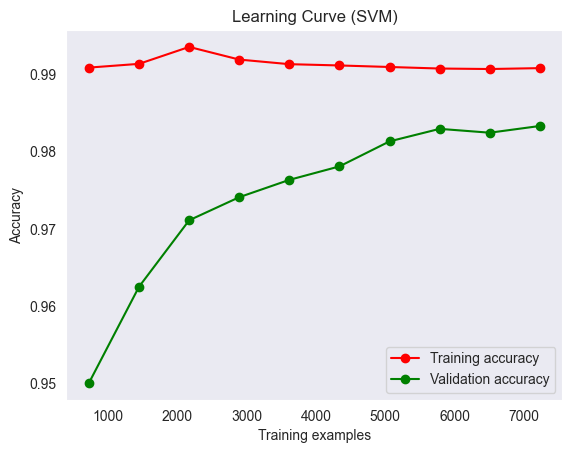

In [55]:
# Istanzia un nuovo modello Random Forest con i migliori parametri ottenuti in precedenza
svc = SVC(random_state=42, **grid_search.best_params_)

# Calcolo la learning curve
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, y_train, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, cv=10)

# Calcola la media dei punteggi ottenuti nelle diverse iterazioni di cross validation
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Traccio la curva di apprendimento
plt.figure()
plt.title("Learning Curve (SVM)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation accuracy")

plt.legend(loc="best")
plt.show()

### 4.2 Matrice di confusione

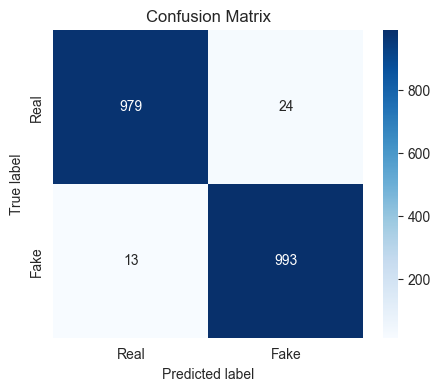

In [56]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Salva il grafico come file PDF
# plt.savefig('confusion_matrix_NameOfClassifier.pdf', format='pdf')

### 4.3 Roc Curve

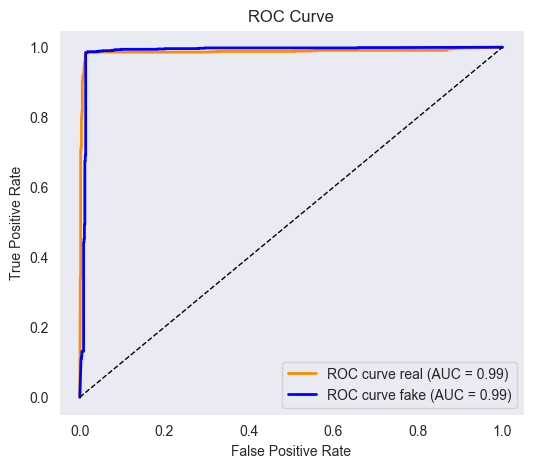

In [58]:
# istanzo un nuovo SVC, con i migliori parametri, al fine di abilitare il metodo predict_proba
svc_proba = SVC(random_state=42, probability=True, **grid_search.best_params_)
svc_proba.fit(X_train, y_train)
y_proba = svc_proba.predict_proba(X_test)

# Calcolo della curva ROC per la classe 'real' (label 0)
fpr_real, tpr_real, _ = roc_curve(y_test, y_proba[:, 0], pos_label=0)
roc_auc_real = auc(fpr_real, tpr_real)

# Calcolo della curva ROC per la classe 'fake' (label 1)
fpr_fake, tpr_fake, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# Tracciamento delle curve ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, color='darkorange', lw=2, label=f'ROC curve real (AUC = {roc_auc_real:.2f})')
plt.plot(fpr_fake, tpr_fake, color='blue', lw=2, label=f'ROC curve fake (AUC = {roc_auc_fake:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()